In [112]:
import pandas as pd

In [113]:
df = pd.read_csv("Theatre Patients Jul 2010 to Sep 2022.csv")

Drop under 18's

In [114]:
df.drop(df.loc[df['Age']<18].index, inplace=True)

In [115]:
df.head()

,Age,Sex,Height (cm),Weight (kg)
0,40.0,Male,189.0,NaN
1,56.0,Female,NaN,NaN
2,51.0,Male,193.5,NaN
3,57.0,Female,NaN,NaN
4,65.0,Male,179.0,NaN


In [116]:
print(df['Sex'].unique())
df['Sex'] = df['Sex'].str.lower()


['Male' 'Female' nan 'male' 'FEMALE' 'female' 'Trans-gend F to M']


In [117]:
df = df[df['Sex'] != 'trans-gend f to m']
sex_map = {'male': 'm', 'female': 'f'}
df['Sex'] = df['Sex'].map(sex_map)
df.dropna(subset=['Sex'], inplace=True)
df['Sex'].value_counts()


f    41229
m    24380
Name: Sex, dtype: int64

In [118]:
cols = ['Age', 'Height (cm)', 'Weight (kg)']

In [120]:
df['Weight (kg)'].quantile(0.99)

129.9

array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Height (cm)'}>],
       [<AxesSubplot: title={'center': 'Weight (kg)'}>, <AxesSubplot: >]],
      dtype=object)

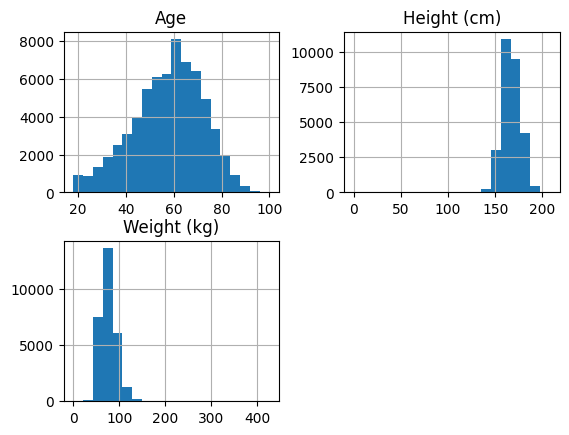

In [121]:
df.hist(bins=20)

There are some extreme values in height and weight which seem implausible. 

We will censor them at a threshold of 99%

In [122]:
import numpy as np

for i in cols[1:]:
    low = df[i].quantile(.01)
    high = df[i].quantile(.999)
    print(f"{i}: low={low}, high={high}")
    df[i] = df[i].mask(df[i] < low, np.nan)
    df[i] = df[i].mask(df[i] > high, np.nan)

Height (cm): low=145.0, high=197.0
Weight (kg): low=44.8, high=170.0


array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Height (cm)'}>],
       [<AxesSubplot: title={'center': 'Weight (kg)'}>, <AxesSubplot: >]],
      dtype=object)

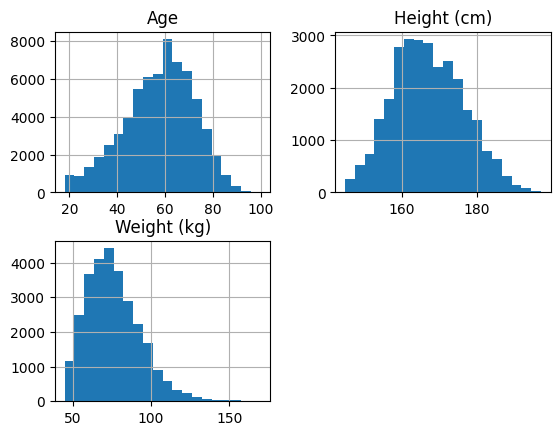

In [123]:
df.hist(bins=20)

In [129]:
from PyTCI.weights.leanbodymass import idealbodyweight

df['ibw'] = df.apply(lambda row: idealbodyweight(row['Height (cm)'], row['Sex']) if row['Height (cm)'] else row, axis=1)
df.describe()

,Age,Height (cm),Weight (kg),ibw
count,65603.000000,28197.000000,28810.000000,28197.000000
mean,57.546698,167.069048,76.298733,60.571508
std,14.744977,9.313171,17.510097,10.040091
min,18.000000,145.000000,44.800000,38.800000
25%,48.000000,160.000000,63.200000,52.700000
50%,59.000000,166.500000,74.000000,59.200000
75%,69.000000,173.800000,86.500000,68.300000
max,100.000000,197.000000,170.000000,90.600000


In [125]:
male = df.loc[df["Sex"] == 'm']
female = df.loc[df["Sex"] == 'f']

In [126]:
male.describe()

,Age,Height (cm),Weight (kg),ibw
count,24378.000000,10798.000000,11160.000000,10798.000000
mean,60.484371,174.781761,83.595618,70.366883
std,14.567316,7.321463,16.176277,6.662596
min,18.000000,145.000000,45.000000,43.300000
25%,53.000000,170.000000,72.300000,66.000000
50%,63.000000,175.000000,82.000000,70.600000
75%,71.000000,180.000000,93.000000,75.100000
max,99.000000,197.000000,170.000000,90.600000


In [127]:
female.describe()

,Age,Height (cm),Weight (kg),ibw
count,41225.000000,17399.000000,17650.000000,17399.000000
mean,55.809533,162.282459,71.684952,54.492396
std,14.573191,6.889745,16.735400,6.269795
min,18.000000,145.000000,44.800000,38.800000
25%,46.000000,157.500000,60.000000,50.100000
50%,56.000000,162.000000,68.200000,54.200000
75%,67.000000,167.000000,80.000000,58.800000
max,100.000000,196.700000,170.000000,85.800000


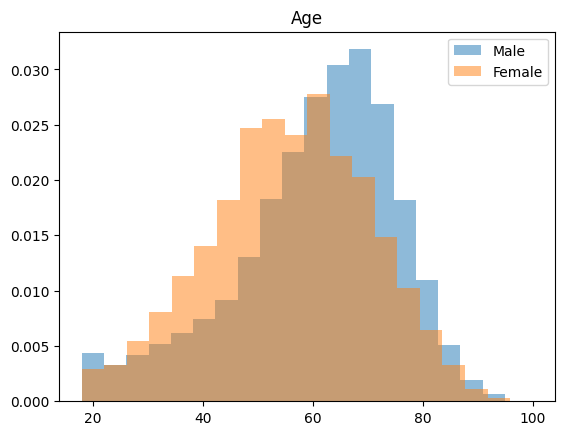

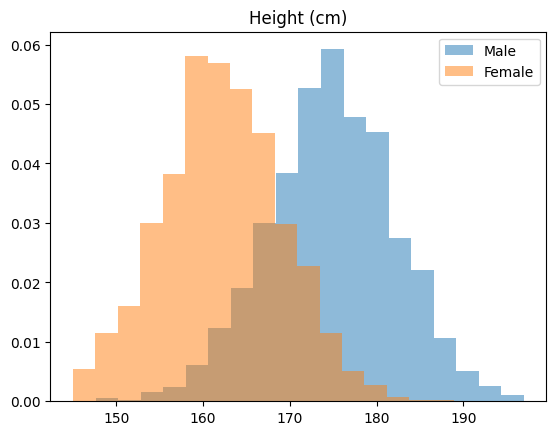

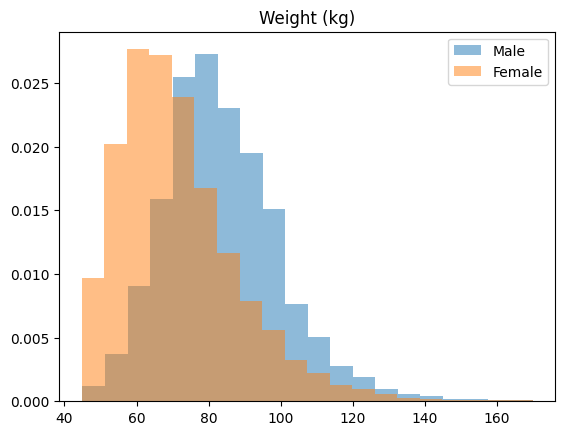

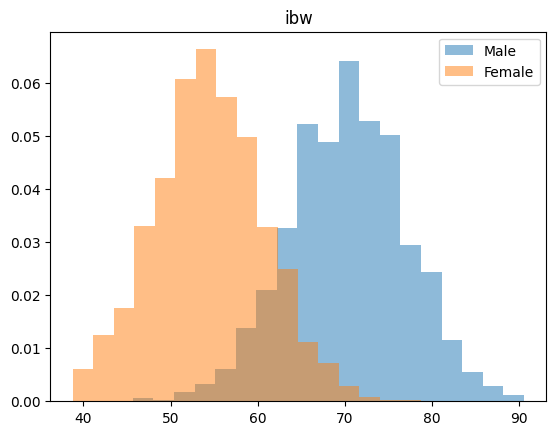

In [128]:
import matplotlib.pyplot as plt

cols.append('ibw')
for i, j in enumerate(cols):
    plt.figure(i)
    plt.title(j)
    plt.hist(male[j], alpha=0.5, density=True, bins=20)
    plt.hist(female[j], alpha=0.5, density=True, bins=20)
    plt.legend(['Male', 'Female'])

In [142]:
tidal_volumes = np.arange(250, 710, 10)
six_ml = tidal_volumes/6
eight_ml = tidal_volumes/8
data = {'Tv': tidal_volumes, '6ml':six_ml, '8ml':eight_ml}

vent_df = pd.DataFrame(data)
vent_df.head()

,Tv,6ml,8ml
0,250,41.666667,31.25
1,260,43.333333,32.50
2,270,45.000000,33.75
3,280,46.666667,35.00
4,290,48.333333,36.25


In [172]:
vent_df['count'] = vent_df['Tv'].apply(lambda x: len(df[(df['ibw'] > x/8) & (df['ibw'] < x/6)]))

vent_df.head()

,Tv,6ml,8ml,count
0,250,41.666667,31.25,300
1,260,43.333333,32.50,756
2,270,45.000000,33.75,1095
3,280,46.666667,35.00,1876
4,290,48.333333,36.25,2961


In [174]:
from bokeh.io import push_notebook, show, output_notebook, export_png
from bokeh.plotting import figure, show
from bokeh.models import Range1d

output_notebook()



Loading BokehJS ...

In [178]:
plot = figure(title="Lung Protective Ventilation count")
plot.line(vent_df['Tv'], vent_df['count'])
show(plot)